In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import acorr_ljungbox

Populating the interactive namespace from numpy and matplotlib


In [2]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

### Analysis on time series about salary

Let's $\alpha = 0.05$

In [3]:
ALPHA = 0.05
LMBDA = 0

In [4]:
df = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=True, dayfirst=True)
df.head(2)

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1


#### Get some statics 

In [5]:
df['WAG_C_M'].describe()

count      284.000000
mean     12193.308099
std      11992.326701
min         15.300000
25%       1191.000000
50%       7195.000000
75%      21365.250000
max      43408.000000
Name: WAG_C_M, dtype: float64

It's good that there're no negative values. It allows us to make multiplicative STL-decomposition on need

#### Look at the time series

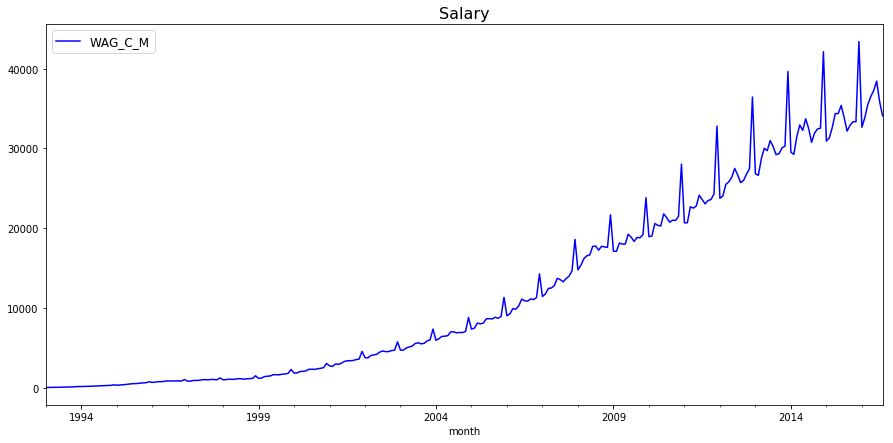

In [6]:
plt.figure(figsize(15,7))
df['WAG_C_M'].plot(color='b', legend='WAG_C_M')
plt.legend(loc='best', fontsize='large')
plt.title('Salary', loc='center', fontsize=16)
plt.show()

It's seems that there're monthly seasonality, increasing trend, not constant variance so there's no obviously stationarity in the series.

Let's try to stable variance using Box-Cox and log and recheck this to choose best

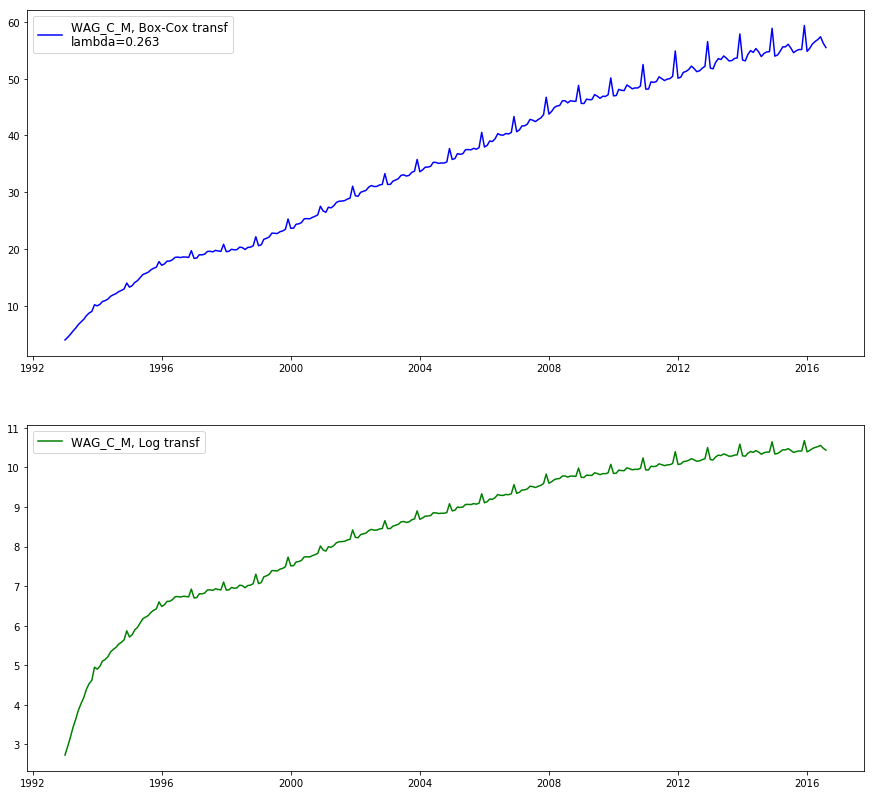

In [26]:
df['wag_box'], LMBDA = stats.boxcox(df['WAG_C_M'])
df['wag_log'] = np.log(df['WAG_C_M'])

plt.figure(figsize(15,14))

plt.subplot(2,1,1)
plt.plot(df.index, df['wag_box'], color='b', label=f'WAG_C_M, Box-Cox transf\nlambda={round(LMBDA, 3)}')
plt.legend(loc='best', fontsize='large')


plt.subplot(2,1,2)
plt.plot(df.index, df['wag_log'], color='g', label='WAG_C_M, Log transf')
plt.legend(loc='best', fontsize='large')

plt.show()

Let's work with Box-Cox transformation further

#### Additive STL-decomposition

<Figure size 1080x720 with 0 Axes>

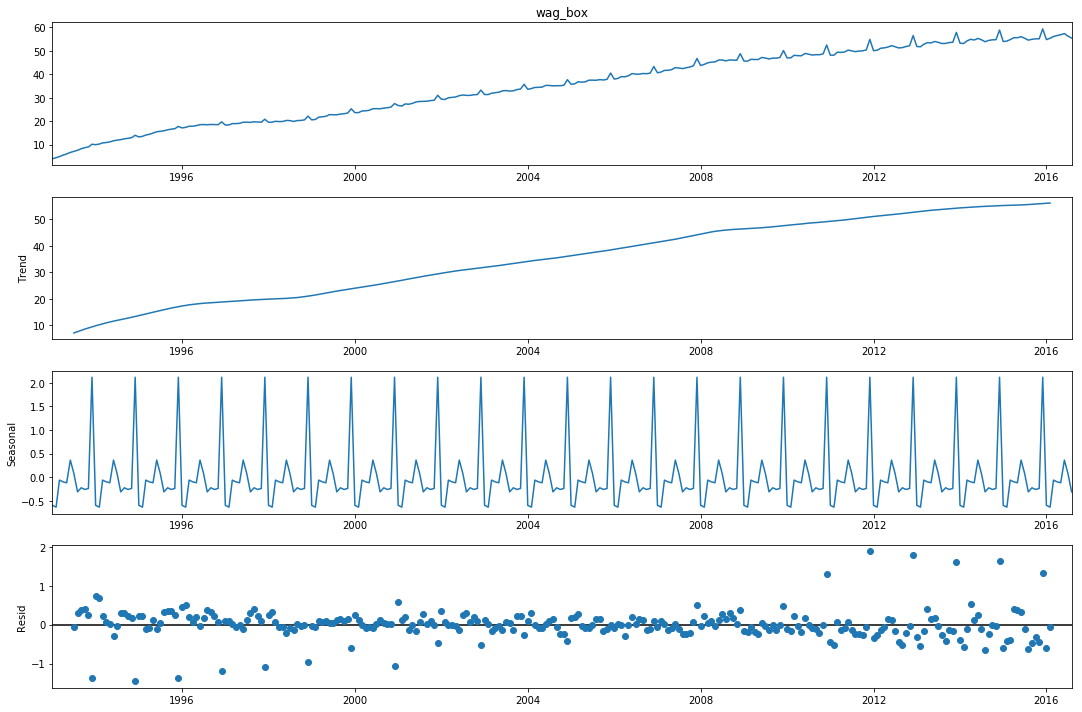

In [27]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df['wag_box'], model='add', period=12).plot()
plt.show()

Steps to make our series be like stationary one:
    1. Since we can see seasonality with monthly, reduce its impact
    2. If times series doesn't look like stationary one, try differentiate it one more time 

<Figure size 1080x720 with 0 Axes>

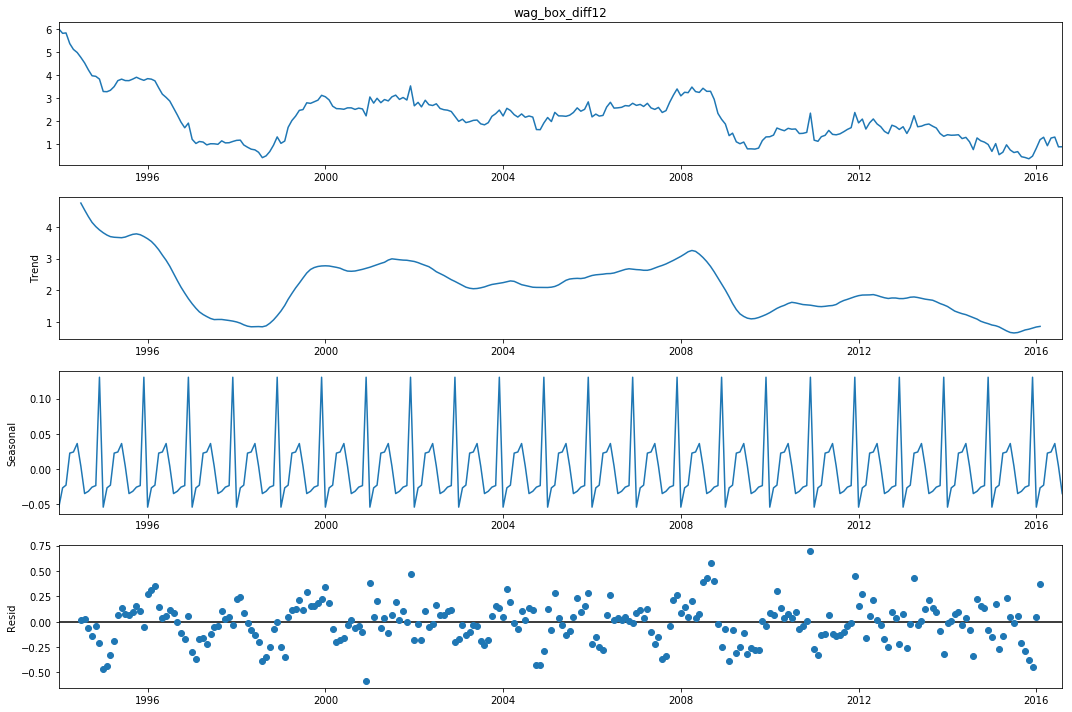

In [28]:
df['wag_box_diff12'] = df['wag_box'] - df['wag_box'].shift(12)

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df['wag_box_diff12'][12:], model='add', period=12).plot()
plt.show()

Looks realy better so check Dickey-Fuller test on nonstationarity of series

In [29]:
print("Dickey-Fuller test:")

p = sm.tsa.stattools.adfuller(df['wag_box_diff12'][12:])[1]

if p >= ALPHA:
    print(f"Time series is nonstationary since {p} > {ALPHA}")
else:
    print(f"Time series is stationary since {p} < {ALPHA}")

Dickey-Fuller test:
Time series is stationary since 0.014697133494791808 < 0.05


A bit difficult, test says that time series is stationary, but in my opinion there's some behaviour in trend in the begining despite the fact that all in all everythig is about constant.
So let's differentiate one more

<Figure size 1080x720 with 0 Axes>

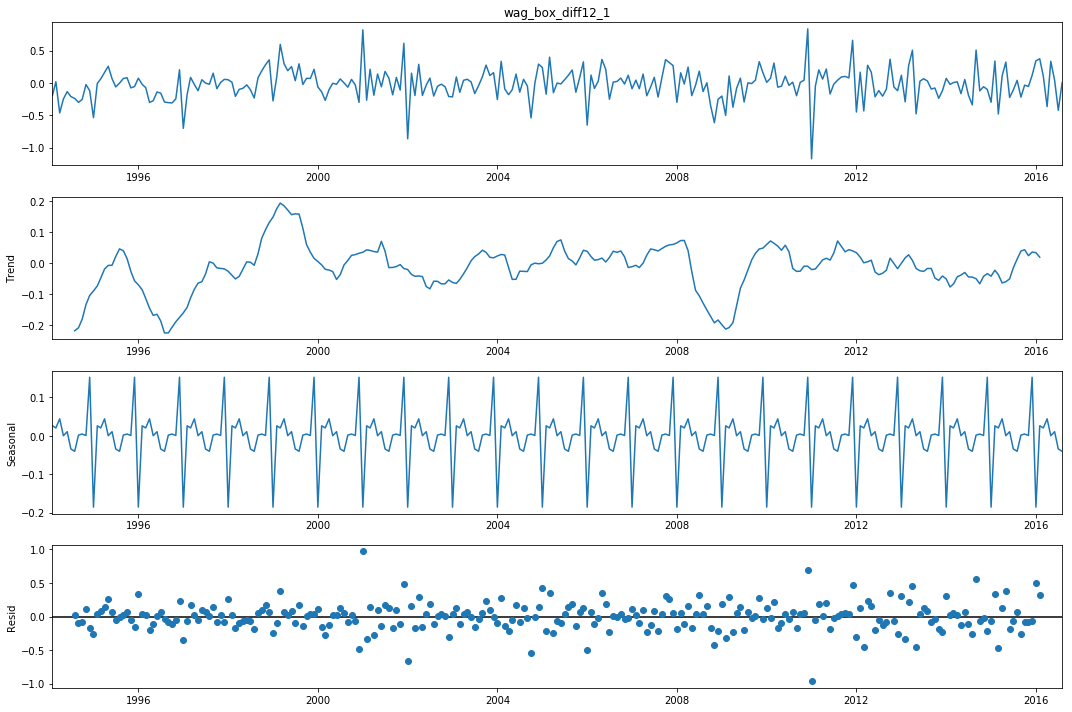

In [30]:
df['wag_box_diff12_1'] = df['wag_box_diff12'] - df['wag_box_diff12'].shift(1)

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df['wag_box_diff12_1'][13:], model='add', period=12).plot()
plt.show()

That's nice here, obviously stationary time series.

Make shure:

In [31]:
print("Dickey-Fuller test:")

p = sm.tsa.stattools.adfuller(df['wag_box_diff12_1'][13:])[1]

if p >= ALPHA:
    print(f"Time series is nonstationary since {p} > {ALPHA}")
else:
    print(f"Time series is stationary since {p} < {ALPHA}")

Dickey-Fuller test:
Time series is stationary since 5.2036037158213736e-08 < 0.05


## ARIMA model

Get parameters p, P, q, Q using ACF and PCF

d = 1, D = 1

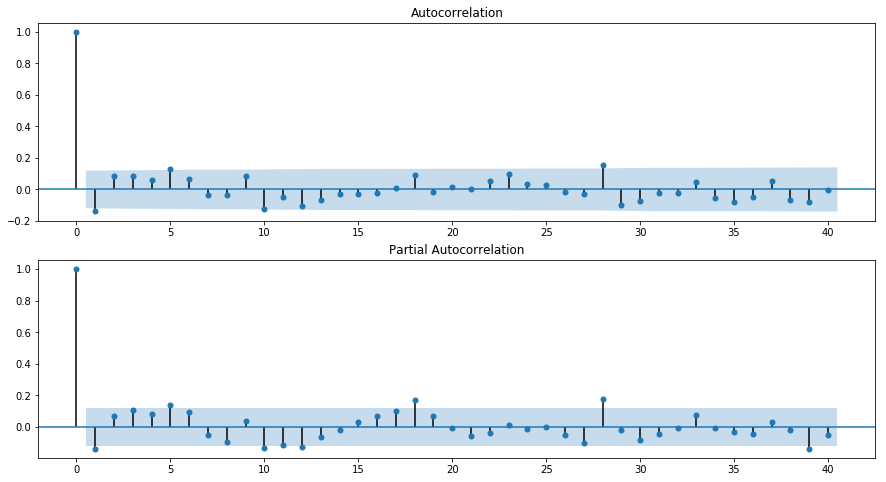

In [53]:
plt.figure(figsize(15,8))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df['wag_box_diff12_1'][13:].values.squeeze(), lags=40, ax=ax)


ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df['wag_box_diff12_1'][13:].values.squeeze(), lags=40, ax=ax)

plt.show()

Reasonable parameters
<br>
Using ACF:

    q = 5, Q = 0
Using PACF:

    p = 5, P = 1

In [36]:
ps = range(0, 6)
Ps = range(0, 2)
qs = range(0, 6)
Q = 0
d = 1
D = 1

In [37]:
parameters = product(ps, qs, Ps)
parameters_list = list(parameters)
len(parameters_list)

72

Fit ARIMA models with those combinations and get the best one using AIC criterion

AIC = -2LN(L) + 2k

In [38]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(df['wag_box'], order=(param[0], d, param[1]), 
                                         seasonal_order=(param[2], D, Q, 12)).fit(disp=False, maxiter=1000)
        results.append([param[0], d, param[1], param[2], D, Q, model.aic])
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Look at top-5

In [39]:
result_table = pd.DataFrame(results, columns=['p', 'd', 'q', 'P', 'D', 'Q', 'aic'])
result_table = result_table.sort_values(by = 'aic', ascending=True)
print(result_table.head())

     p    d    q    P    D    Q        aic
118  4  1.0  5.0  1.0  1.0  0.0 -28.002906
142  5  1.0  5.0  1.0  1.0  0.0 -27.646244
116  4  1.0  5.0  0.0  1.0  0.0 -25.324072
140  5  1.0  5.0  0.0  1.0  0.0 -23.465991
56   2  1.0  2.0  0.0  1.0  0.0 -21.488595


Best model summary information:

In [40]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                             wag_box   No. Observations:                  284
Model:             SARIMAX(4, 1, 5)x(1, 1, [], 12)   Log Likelihood                  25.001
Date:                             Fri, 03 Apr 2020   AIC                            -28.003
Time:                                     01:28:29   BIC                             11.620
Sample:                                 01-01-1993   HQIC                           -12.094
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6681      0.126      5.311      0.000       0.422       0.915
ar.L2         -0.4217      

## Analysis of residuals

Check residuals of best model

Shapiro-Wilk test:
Time series's residuals is not normal distributed since 2.5402400309834922e-23 < 0.05

Dickey-Fuller test:
Time series's residuals is stationary since 2.9565373396853513e-29 < 0.05

Ljung-Box test with 24 lags (2*m, where m - period of seasonality):
Time series's residuals is autocorrelated since 0.02837470771155633 < 0.05

t-test one sample:
Time series's residuals is not biased since 0.17833932790183446 > 0.05


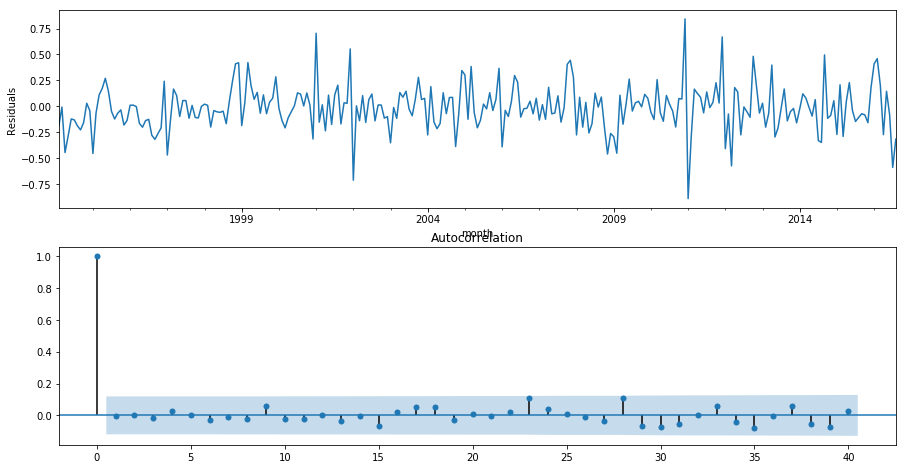

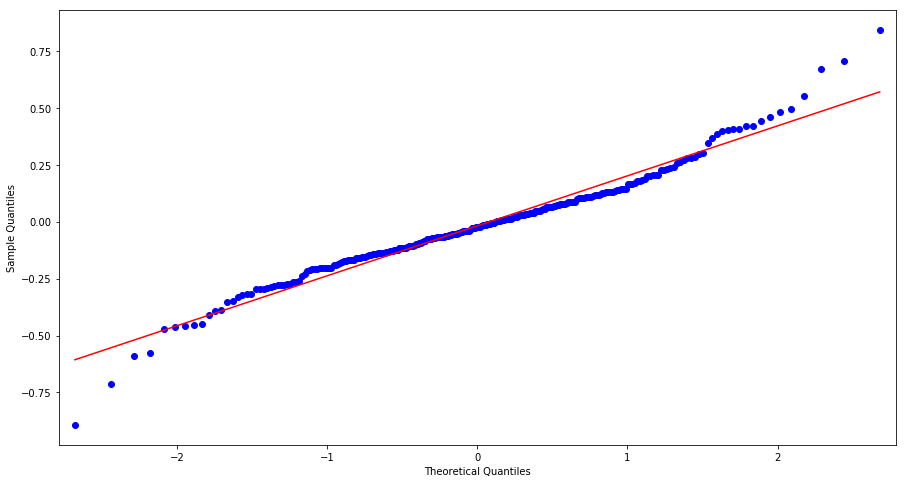

In [41]:
print("Shapiro-Wilk test:")

p_shap = shapiro(best_model.resid)[1]

if p_shap >= ALPHA:
    print(f"Time series's residuals is normal distributed since {p_shap} > {ALPHA}")
else:
    print(f"Time series's residuals is not normal distributed since {p_shap} < {ALPHA}")

#######################################################################################################   

print("\nDickey-Fuller test:")

p_df = sm.tsa.stattools.adfuller(best_model.resid[13:])[1]

if p_df >= ALPHA:
    print(f"Time series's residuals is nonstationary since {p_df} > {ALPHA}")
else:
    print(f"Time series's residuals is stationary since {p_df} < {ALPHA}")

#######################################################################################################

print("\nLjung-Box test with 24 lags (2*m, where m - period of seasonality):")

p_lj = acorr_ljungbox(best_model.resid, lags=[24], return_df=False)[1][0]

if p_lj >= ALPHA:
    print(f"Time series's residuals is not autocorrelated since {p_lj} > {ALPHA}")
else:
    print(f"Time series's residuals is autocorrelated since {p_lj} < {ALPHA}")

#######################################################################################################

print("\nt-test one sample:")

p_t = stats.ttest_1samp(best_model.resid[13:], 0)[1]

if p_t >= ALPHA:
    print(f"Time series's residuals is not biased since {p_t} > {ALPHA}")
else:
    print(f"Time series's residuals is biased since {p_t} < {ALPHA}")


plt.figure(figsize(15,8))

plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=40, ax=ax)

sm.qqplot(best_model.resid[13:], line='r')
plt.show()

## Check suitability

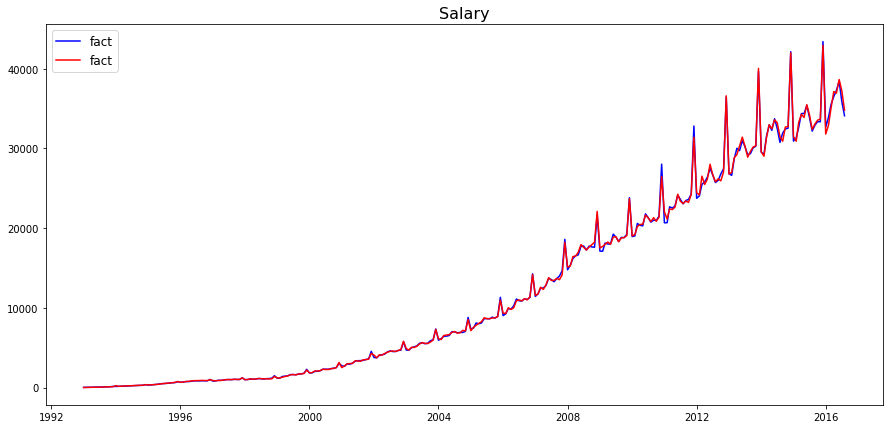

In [42]:
df['pred'] = invboxcox(best_model.fittedvalues, LMBDA)

plt.figure(figsize(15,7))
plt.plot(df.index, df['WAG_C_M'], color='b', label='fact')
plt.plot(df.index, df['pred'], color='r', label='fact')
plt.legend(loc='best', fontsize='large')
plt.title('Salary', loc='center', fontsize=16)
plt.show()

Looks really good

## Forecasting

Let's cut off one period of seasons (12 months) and predict it, then check MAE.
<br>
Since log transformation was done then we have to inverse result using invbox function with $\lambda = 0.263$

In [43]:
df.head(1)

,WAG_C_M,wag_box,wag_log,wag_box_diff12,wag_box_diff12_1,pred
month,,,,,,
1993-01-01,15.3,3.990393,2.727853,NaN,NaN,1.0


In [44]:
date_list = df[-12:].index
df2 = pd.DataFrame(columns=['pred', 'fact'], index=date_list)
df2['pred'] = invboxcox(best_model.predict(start=len(df) - 12, end=len(df) - 1), LMBDA)
df2['fact'] = df.iloc[-12:, 0]

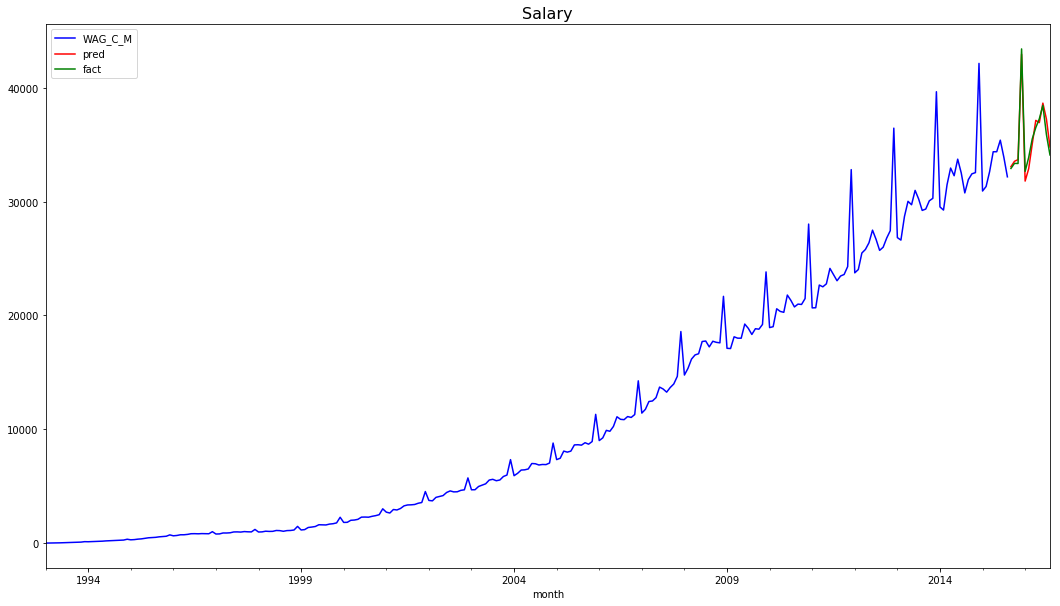

In [45]:
plt.figure(figsize(18,10))
df.iloc[:-12, 0].plot(color='b')
df2.loc[:, 'pred'].plot(color='r', legend='pred')
df2.loc[:, 'fact'].plot(color='g', legend='fact')
plt.title('Salary', loc='center', fontsize=16)
plt.legend(loc='best')
plt.show()

## MAE

In [46]:
mae = sum(abs(df2['pred'] - df2['fact'].values)) / 12
print(f"MAE: {mae}")

MAE: 556.9287308244678


## More forecasting

In [47]:
df.index[-1]

Timestamp('2016-08-01 00:00:00')

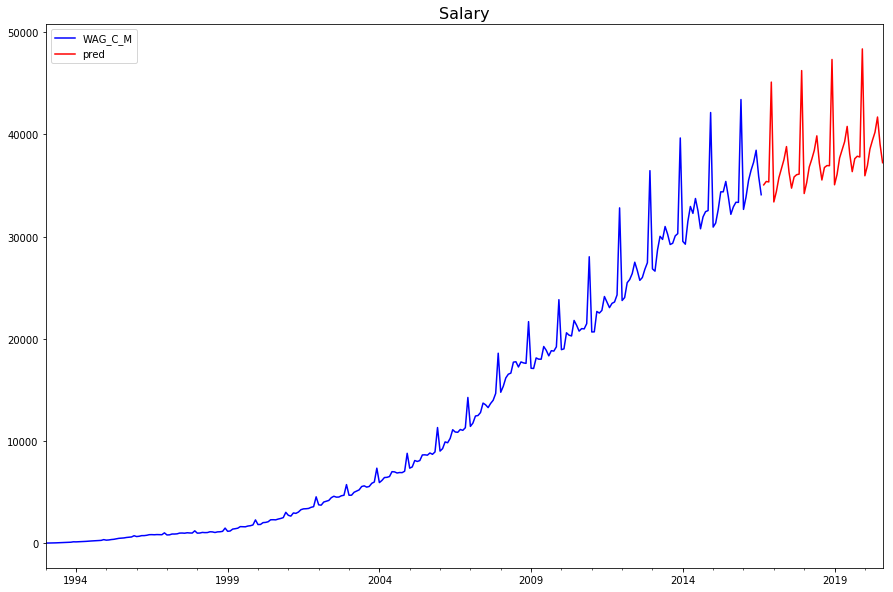

In [48]:
cnt_months = 48
df3 = df[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x)
             for x in range(cnt_months)]
future = pd.DataFrame(index=date_list, columns= df3.columns)
df3 = pd.concat([df3, future])
df3['pred'] = invboxcox(best_model.predict(start=len(df), end=len(df)+cnt_months), LMBDA)

plt.figure(figsize(15,10))
df3.loc[:, 'WAG_C_M'].plot(color='b', legend='fact')
df3.loc[:, 'pred'].plot(color='r', legend='pred')
plt.title('Salary', loc='center', fontsize=16)
plt.show()